# Resolver EDPs en computadores



# Algunas barreras conceptuales

- Números no tienen representación decimal exacta
- Objetos matemáticos tampoco
- Ecuaciones diferenciales entregan _función_
- Ecuaciones no tienen solución analítica
- Ecuaciones tienen _infinitas_ propiedades -> sistemas discretos no!

# Ejemplo

$$
    \begin{aligned}
        -\Delta u &= f && \text{en $\Omega$} \\
        u &= 0 && \text{en $\partial\Omega$} 
    \end{aligned}
$$

con $\Omega = (0,1) \times (0,1) $ 

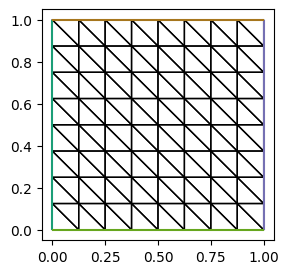

In [26]:
from firedrake import *
from time import perf_counter as time
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,3]

N=8
mesh = UnitSquareMesh(N,N) 
V = FunctionSpace(mesh, 'CG', 1)
u = Function(V)
du = TrialFunction(V)
v = TestFunction(V)
_ = triplot(mesh)

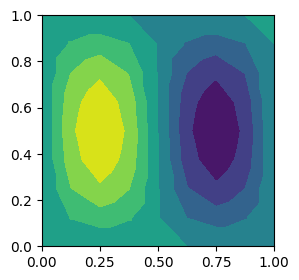

In [27]:
x,y = mesh.coordinates
f = sin(2*pi*x) * sin(pi*y)
a = dot(grad(du), grad(v)) * dx
bc = DirichletBC(V, Constant(0), "on_boundary")
solve(a==f*v*dx, 
      u, 
      bcs=bc)


_ = tricontourf(u) # triplot(mesh)

In [28]:
from scipy.sparse.linalg import splu

def mat2scipy(mat):
    indptr, indices, data = mat.M.handle.getValuesCSR()
    return sp.csr_matrix((data, indices, indptr), shape=mat.M.handle.getSize())

def solveLaplacian(N, method):
    mesh = UnitCubeMesh(N, N, N)
    V = FunctionSpace(mesh, 'CG', 1)
    u = Function(V)
    du = TrialFunction(V)
    v = TestFunction(V)
    
    x,y,z = mesh.coordinates
    f = sin(2*pi*x) * sin(pi*y)
    a = dot(grad(du), grad(v)) * dx
    f = f * v * dx
    bc = DirichletBC(V, Constant(0), "on_boundary")
    t0 = time()
    solve(a==f, u, bc, solver_parameters={"ksp_type": "cg", "pc_type": method})
    sol_time = time() - t0
    A = assemble(a, bcs=bc)
    nnz = A.M.sparsity.nnz.sum()
    
    
    if method == "lu":
        A_sp = mat2scipy(A)
        LU = splu(A_sp)
        return sol_time, LU.nnz
    else: 
        return sol_time, nnz, V.dim()


# Procedimiento

Problema: Encontrar $u$ en $V$ tal que 
    $$
        \begin{aligned}
            -\Delta u &= f &&\text{en $\Omega$} \\
            u &= g         &&\text{en $\partial\Omega$}
        \end{aligned}
    $$
1. Discretizar la geometría
2. Discretizar el espacio funcional
3. Discretizar el problema
4. Resolver

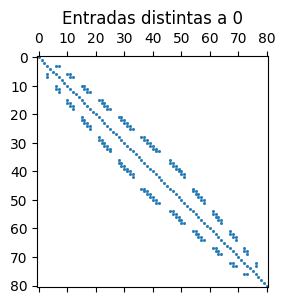

In [29]:
# Exploremos la matriz
import scipy.sparse as sp
from scipy.sparse.linalg import splu
A = assemble(a, bcs=bc)
indptr, indices, data = A.M.handle.getValuesCSR()
scipy_mat = sp.csr_matrix((data, indices, indptr), shape=A.M.handle.getSize())

plt.spy(scipy_mat, markersize=1)
plt.title("Entradas distintas a 0")
plt.show()

In [30]:
nnzs_LU = []
nnzs_A = []
dofs = []
times_lu = []
times_amg = []
for n in range(5,21,5):
    print(f"Solving n={n}")
    time_lu, nnz_LU  = solveLaplacian(n, 'lu')
    time_amg, nnz_A, dof = solveLaplacian(n, 'hypre')
    nnzs_LU.append(nnz_LU); nnzs_A.append(nnz_A)
    dofs.append(dof); times_lu.append(time_lu); times_amg.append(time_amg)

Solving n=5
Solving n=10


/home/nico/firedrake/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


Solving n=15
Solving n=20


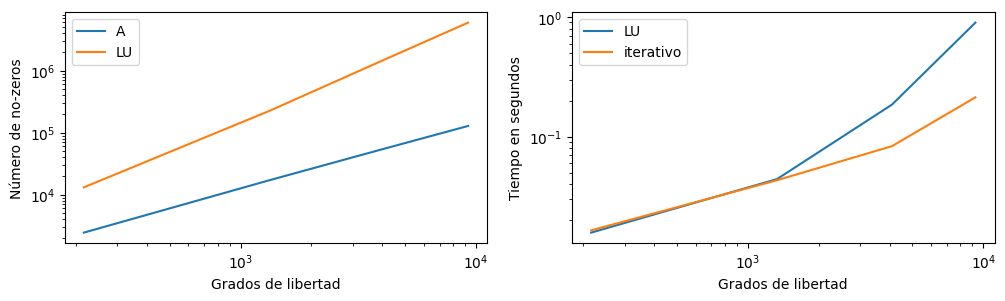

In [31]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12,3]

plt.subplot(121)
plt.loglog(dofs, nnzs_A, label="A")
plt.loglog(dofs, nnzs_LU, label="LU")
plt.xlabel("Grados de libertad")
plt.ylabel("Número de no-zeros")
plt.legend()
plt.subplot(122)
plt.loglog(dofs, times_lu, label="LU")
plt.loglog(dofs, times_amg, label="iterativo")
plt.xlabel("Grados de libertad")
plt.ylabel("Tiempo en segundos")
plt.legend()
plt.show()

# Quién tiene la culpa?

- Memoria: _fill-in_
- Tiempo: Complejidad

(Pizarra)

# Discretización del operador

- De operador diferencial a matriz
    $$ \Delta u \mapsto \mathbf A \mathbf u \in \mathbb R^n $$
    

# Discretización por diferencias finitas

- Podemos aproximar funciones con Taylor
    $$ f(x+h) \approx f(x)+ f'(x)h + O(h^2)$$
    

In [32]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [3,3]

def f(x):
    return np.sin(x)

def df(x):
    return np.cos(x)

def f_approx(x, h):
    return f(x) + df(x) * h

errors_f=[]
errors_df = []
hs = [10**k for k in range(1, -8, -1)]
x = 0.1
for h in hs:
    error_f = abs(f(x+h) - f_approx(x, h))
    errors_f.append(error_f)
    error_df = abs( (f(x+h) - f(x))/h - df(x) )
    errors_df.append(error_df)

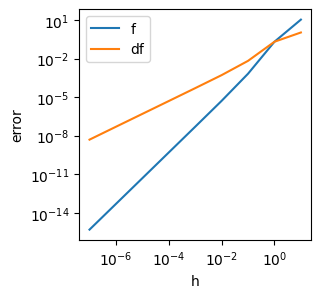

In [33]:
plt.loglog(hs, errors_f, label = "f")
plt.loglog(hs, errors_df, label="df")
plt.legend()
plt.xlabel("h")
plt.ylabel("error")
plt.show()

# Preguntas

- Por qué empiezan de manera errática? (derecha a izquierda)
- Por qué el error en la derivada es distinto?

# Pequeña mejora

$$ f(x+h) = f(x) + f'(x)h + \frac 1 2f''(x)h^2 + O(h^3) $$
$$ f(x-h) = f(x) - f'(x)h + \frac 1 2f''(x)h^2 + O(h^3) $$

Restar:

$$ f'(x) = \frac{f(x+h) - f(x-h)}{2h} + O(h^3) $$

In [34]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    return np.sin(x)

def df(x):
    return np.cos(x)

def f_approx(x, h):
    return f(x) + df(x) * h

errors_f=[]
errors_df = []
errors_centr = []
hs = [10**k for k in range(1, -8, -1)]
x = 0.1
for h in hs:
    error_f = abs(f(x+h) - f_approx(x, h))
    errors_f.append(error_f)
    error_df = abs( (f(x+h) - f(x))/(h) - df(x) )
    errors_df.append(error_df)
    error_centr = abs( (f(x+h) - f(x-h))/(2*h) - df(x) )
    errors_centr.append(error_centr)

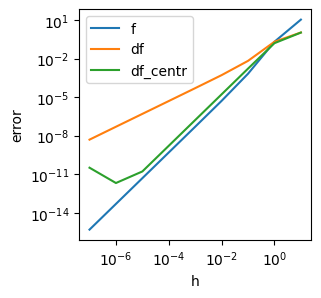

In [35]:
plt.loglog(hs, errors_f, label = "f")
plt.loglog(hs, errors_df, label="df")
plt.loglog(hs, errors_centr, label="df_centr")
plt.legend()
plt.xlabel("h")
plt.ylabel("error")
plt.show()